In [1]:
import numpy as np
import shap
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers
from tensorflow import keras
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')

## Wyjaśnianie predykcji modelu przy pomocy algorytmów z rodziny Shap

Shap to zbiór metod pozwalających na lokalne wyjaśnienie wyników predykcji modelu. Lokalność oznacza w tym pzypadku analizowanie predykcji dla konkretnej próbki wejściowej, a nie próba zinterpretowania wewnętrznej wiedzy modelu. Nazwa metody pochodzi od znanych z teorii gier współczynników "Shap values", które opisują najbardziej sprawiedliwy podział nagrody uzyskanej w wyniku gry kooperacyjnej pomiędzy graczy biorących udział w grze - każdy otrzymuje odpowiednią część wygranej według kontrybucji do uzyskania nagrody.

W ogólnym założeniu podział nagrody między graczy opiera się o następujące zasady:
- Additivity: suma nagród dla poszczególnych graczy jest równa nagrodzie całego zespołu
- Consistency: gracze mający większy wpływ na zysk zespołu nie powinni otrzymać nagrody mniejszej od graczy mniej wpływowych

W przypadku interpretowalności modelu współczynniki Shap values są wykorzystywane, aby obliczyć wkład każdej cechy próbki wejściowej do wyników predykcji.

Więcej na temat teorii stojącej za algorytmami Shap można znaleźć na przykład tutaj:
https://youtu.be/0yXtdkIL3Xk

## Ładowanie datasetu

In [2]:
data = tf.keras.datasets.cifar10.load_data()

In [4]:
train_data, test_data = data
X_train, y_train = train_data
X_test, y_test = test_data

y_train = y_train.flatten()
y_test = y_test.flatten()

X_train_prep = preprocess_input(X_train.copy())
X_test_prep = preprocess_input(X_test.copy())

X_train_prep.shape, X_test_prep.shape, y_train.shape, y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000,), (10000,))

In [5]:
class_names = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

shap_labels = np.array([list(class_names.values())])

## Konfiguracja modelu sieci

In [6]:
input_shape = X_train[0].shape
num_classes = 10

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        # layers.Flatten(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0

In [7]:
model.load_weights('cifar_weights_custom.h5')
test_preds = model.predict(X_test_prep)
test_preds_classes = np.argmax(test_preds, axis=-1)
test_accuracy = np.mean(test_preds_classes == y_test)

print('test accuracy:', round(test_accuracy, 2))

test accuracy: 0.75


## Konstrukcja deep explainera

Tworzymy instancję explainera. W celu realizacji algorytmu DeepExplainer konieczny jest referencyjny backgroud reprezentujący neutralne wejście do modelu. Na jego podstawie algorytm determinuje wpływ każdego piksela na wynik predykcji. Biblioteka shap umożliwia podanie jako tła wycinka zbioru danych, na podstawie którego wyznacza oczekiwane wartości cech próbki neutralnej.

In [39]:
np.random.seed(1)
background = X_train_prep[np.random.choice(X_train_prep.shape[0], 100, replace=False)]
explainer = shap.DeepExplainer(model, background)

## Explaining przykładowej próbki

airplane:    	0.0
automobile:    	1.0
bird:    	0.0
cat:    	0.0
deer:    	0.0
dog:    	0.0
frog:    	0.0
horse:    	0.0
ship:    	0.0
truck:    	0.0


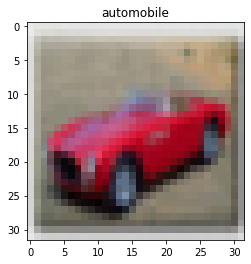

In [13]:
sample_idx = 1234
sample_img = X_test[sample_idx]
sample_img_prep = X_test_prep[sample_idx]

sample_label = y_test[sample_idx]
sample_pred = test_preds[sample_idx]

for i in range(10):
    rounded_pred = str(sample_pred[i].round(3))
    print(f'{class_names[i]}:    \t{rounded_pred}')
    
plt.imshow(sample_img)
plt.title(class_names[sample_label])
plt.show()

In [40]:
%%time
batch = sample_img_prep[np.newaxis, :]
batch_shap = explainer.shap_values(batch)
sample_img_shap = batch_shap[0]

CPU times: user 34.4 s, sys: 14.2 s, total: 48.6 s
Wall time: 18.1 s


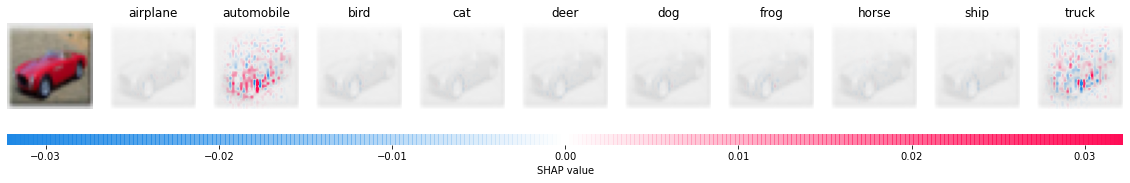

In [41]:
def prep_img(img):
    '''
    Funkcje pomocnicze w bibliotece shap odpowiedzialne za rysowanie wykresów 
    wymagają odpowiedniego formatu obrazu wejściowego.
    '''
    return np.array([img / 255])

shap.image_plot(batch_shap, prep_img(sample_img), labels=shap_labels)

## Analiza próbek z trudno rozróżnialnych klas

Głównym zastosowaniem algorytmów lokalnego wyjaśniania predykcji modelu jest zwizualizowanie cech danych wejściowych najbardziej wpływających na wynik predykcji. W przypadku klasyfikacji obrazów jest to równoznaczne z identyfikacją kluczowych obszarów próbki wejściowej. W następnej części tutoriala skupimy się na próbie zdefiniowania różnic pomiędzy klasami, które okazały się dla naszej sieci najtrudniejsze w rozróżnieniu.

## Wizualizacja zbioru danych przy pomocy PCA

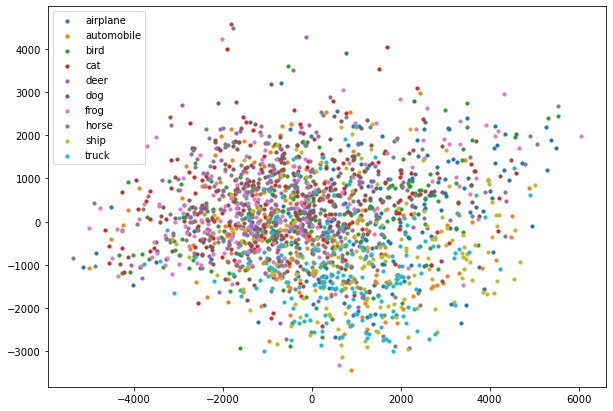

In [44]:
batch_size = 2_000
batch_indices = np.random.choice(len(X_train), batch_size, replace=False)
X_batch = X_train[batch_indices].reshape((-1, 32 * 32 * 3))
batch_labels = y_train[batch_indices]

pca = PCA(n_components=2).fit(X_batch)
X_batch_2d = pca.transform(X_batch)

plt.figure(figsize=(10, 7))

for i, name in class_names.items():
    class_indices = batch_labels == i
    X_class = X_batch_2d[class_indices]
    plt.scatter(X_class[:, 0], X_class[:, 1], s=10, label=name)
    
plt.legend()
plt.show()

Niestety PCA nie pozwoliło uzyskać informacji na temat potencjalnych podobieństw pomiedzy poszczególnymi klasami.

## Analiza confusion matrix dla predykcji na zbiorze testowym

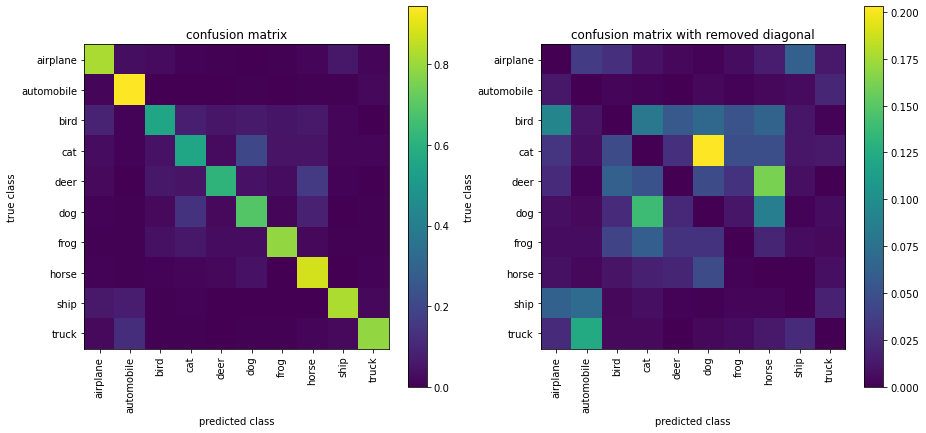

In [45]:
conf_mat = confusion_matrix(y_test, test_preds_classes, normalize='true')

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(conf_mat)
labels = list(class_names.values())
plt.xticks(range(10), labels=labels, rotation=90)
plt.yticks(range(10), labels=labels)
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.title('confusion matrix')
plt.colorbar()

plt.subplot(1, 2, 2)
conf_mat_masked = conf_mat.copy()
for i in range(10):
    conf_mat_masked[i, i] = 0
    
plt.imshow(conf_mat_masked)
labels = list(class_names.values())
plt.xticks(range(10), labels=labels, rotation=90)
plt.yticks(range(10), labels=labels)
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.title('confusion matrix with removed diagonal')
plt.colorbar()

plt.show()

Dzięki analizie confusion matrix dochodzimy do wniosku, że model najczęściej myli między sobą zdjęcia następujących klas:
- koty vs psy
- konie vs jelenie
- samochody vs ciężarówki
- ptaki vs samoloty

## Analiza Shap values - porównanie kluczowych obszarów obrazków podobnych klas

W tej części badamy, które obszary zdjęć wejściowych są dla modelu kluczowe w przypadku rozróżnienia podobnych klas. W tym celu wybraliśmy przykłady ze zbioru testowego, które zostały poprawnie zaklasyfikowane przez model, a następnie szukaliśmy na nich charakterystycznych cech wyróżniających daną klasę. Bardzo pomocne przy analizie Shap values okazało się przetworzenie wyników explainera przez filtr z rozmyciem gaussowskim - dzięki niemu heatmapa prezentująca wkład pikseli w predykcje jest zdecydowanie mniej zaszumiona i łatwiejsza do analizy.

In [108]:
def compare_shap(shap_values, explained_classes, imgs):
    np_shap = np.array(shap_values)
    class_labels = [class_names[c] for c in explained_classes]
    classes_shap = np_shap[explained_classes]
    for i, img in enumerate(imgs):
        img_shap = list(classes_shap[:, i:i+1])
        shap.image_plot(img_shap, prep_img(img), np.array([class_labels]))
        
        
def blur_shap_values(shap_values, sigma):
    classes_count = len(shap_values)
    samples_count = shap_values[0].shape[0]
    
    blurred_shap_values = []
    for class_idx in range(classes_count):
        blurred = []
        for sample_idx in range(samples_count):
            blurred.append(gaussian_filter(shap_values[class_idx][sample_idx], sigma=sigma))
        blurred_shap_values.append(blurred)
    return blurred_shap_values

## Analiza Shap values: koty vs psy

In [47]:
cat_class = 3
dog_class = 5

# ręcznie dobrane przykłady
cat_indices = [103, 336, 432, 558, 573, 673, 874]
dog_indices = [39, 42, 181, 190, 207, 232, 319]

In [48]:
indices = cat_indices
samples = X_test[indices]
samples_prep = X_test_prep[indices]

samples_shap = explainer.shap_values(samples_prep)
compare_shap(samples_shap, [cat_class, dog_class], samples)

AttributeError: 'list' object has no attribute 'shape'

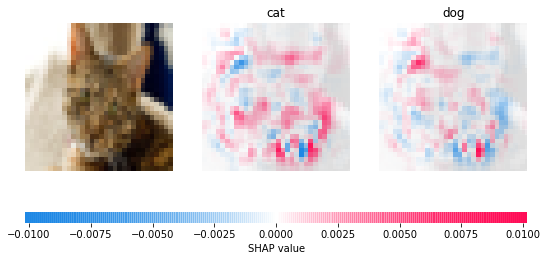

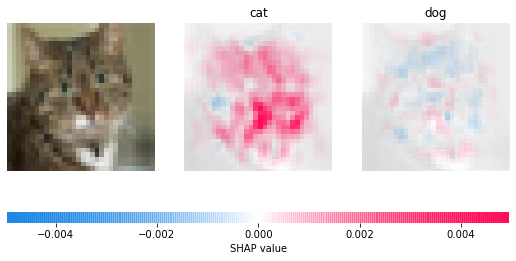

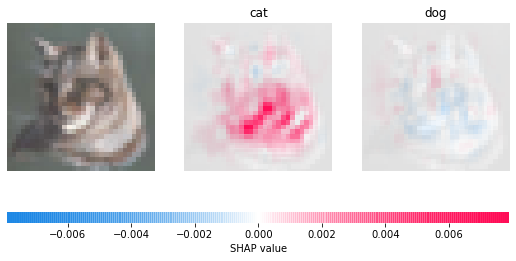

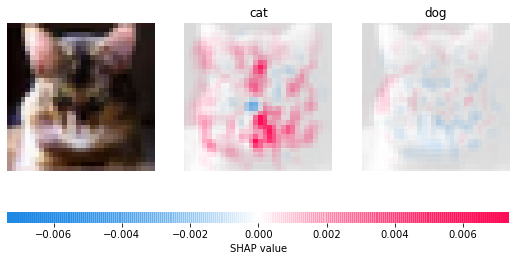

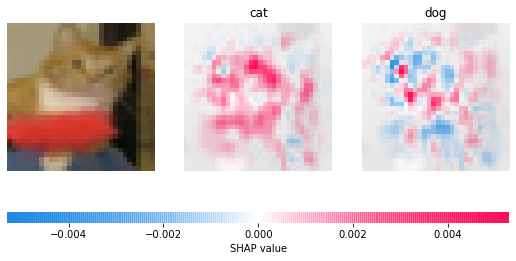

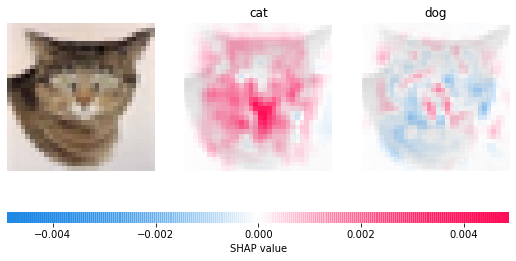

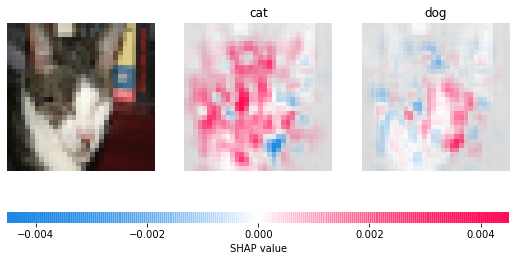

In [52]:
samples_shap_blurred = blur_shap_values(samples_shap, sigma=1)
compare_shap(samples_shap_blurred, [cat_class, dog_class], samples)

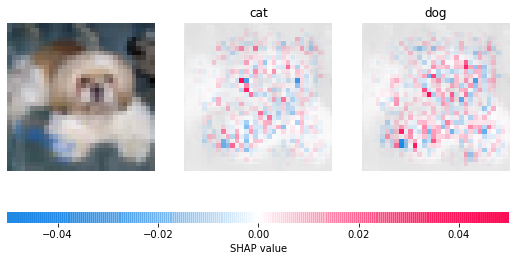

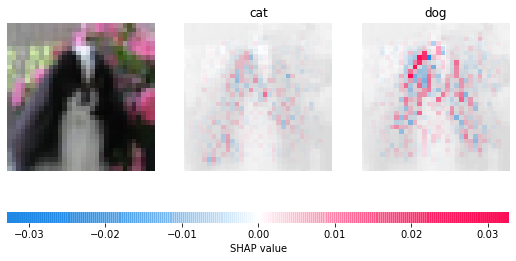

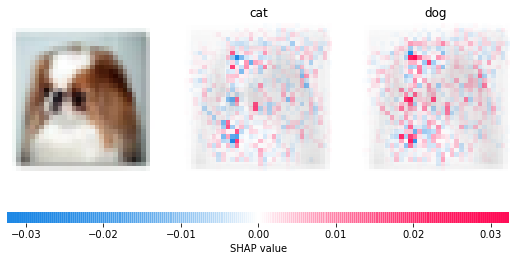

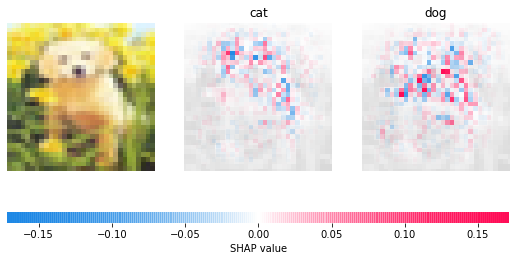

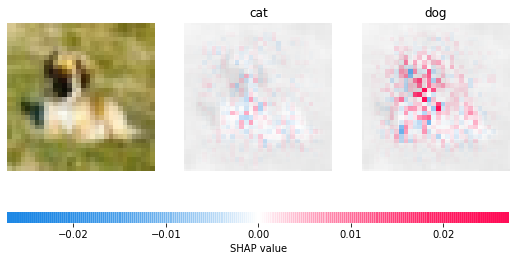

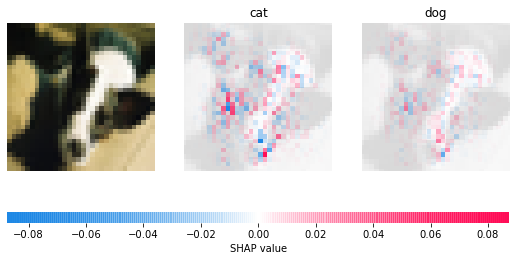

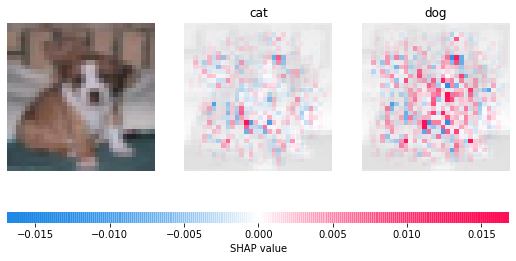

In [53]:
indices = dog_indices
samples = X_test[indices]
samples_prep = X_test_prep[indices]

samples_shap = explainer.shap_values(samples_prep)
compare_shap(samples_shap, [cat_class, dog_class], samples)

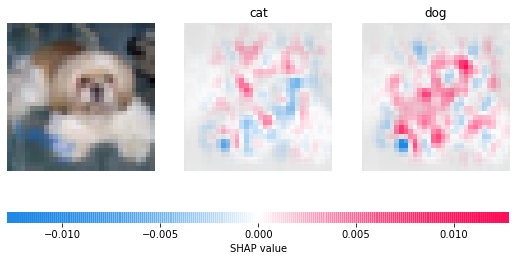

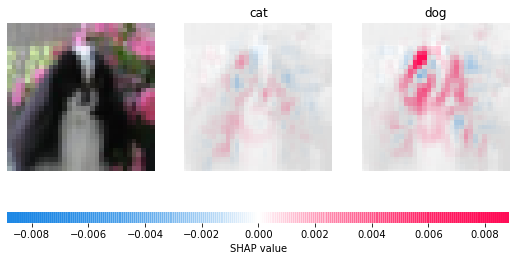

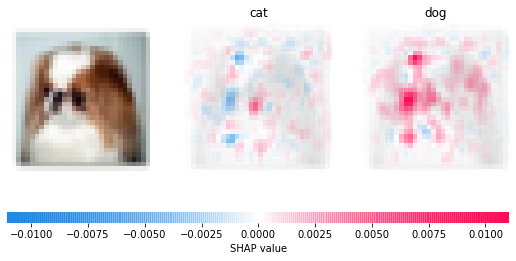

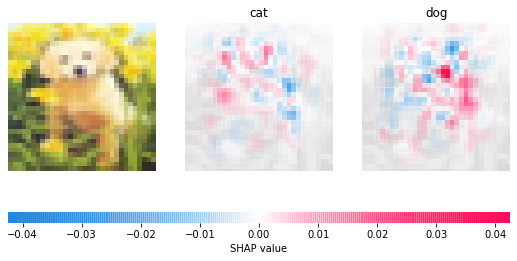

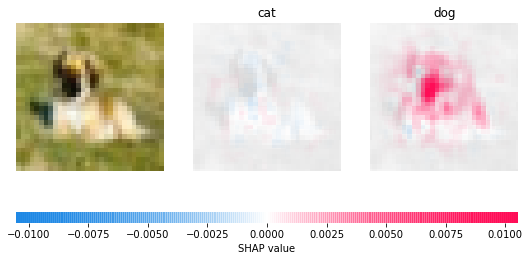

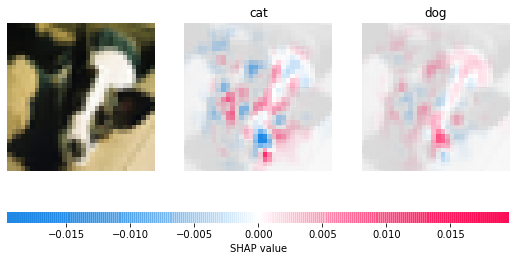

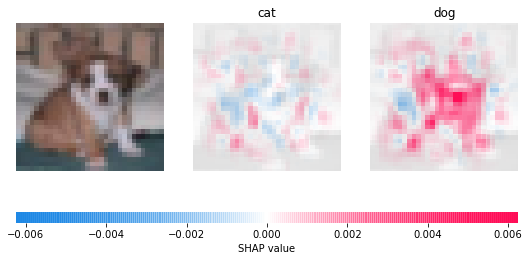

In [54]:
samples_shap_blurred = blur_shap_values(samples_shap, sigma=1)
compare_shap(samples_shap_blurred, [cat_class, dog_class], samples)

Większość zdjęć nie dała czytelnych rezultatów po przetworzeniu przez explainer. Po selekcji próbek, na których dało się zobaczyć obszary decydujące o predykcji modelu, doszliśmy do wniosku, że głównym kryterium, po którym model rozróżnia koty od psów, jest kształt ich pyska. W przypadku kotów często czerwonym kolorem podkreślone są krótkie podbródki i charakterystyczne nosy. W przypadku psów przeważnie obszarem decydującym był cały pysk.

## Analiza Shap values: konie vs jelenie

In [55]:
deer_class = 4
horse_class = 7

# ręcznie dobrane przykłady
deer_indices = [22, 36, 40, 117, 159, 227, 505]
horse_indices = [13, 17, 83, 109, 210, 216, 506]

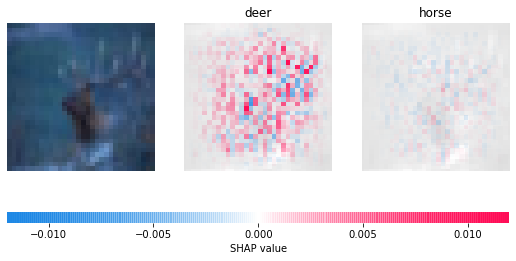

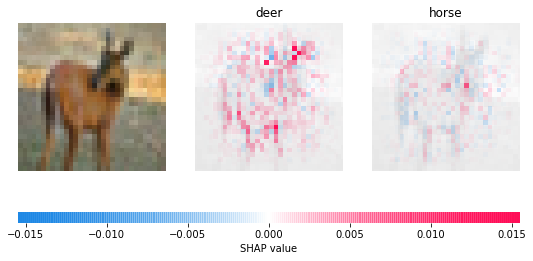

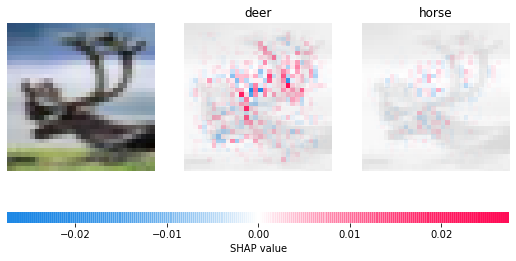

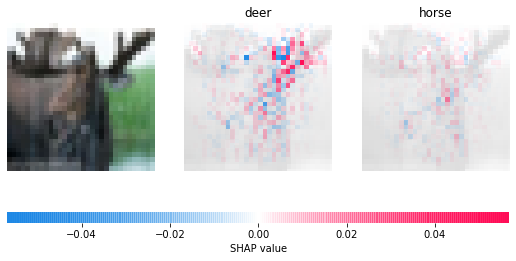

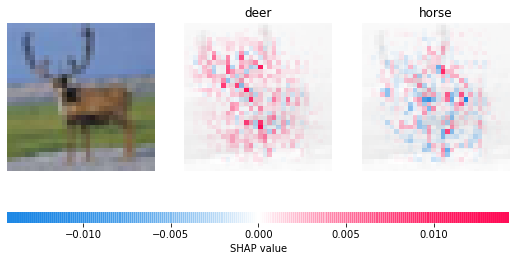

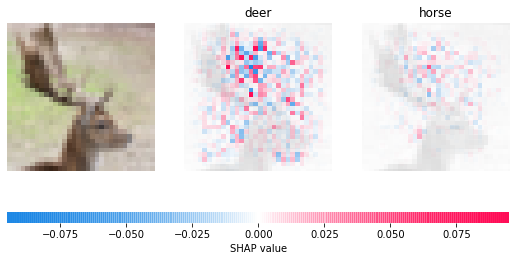

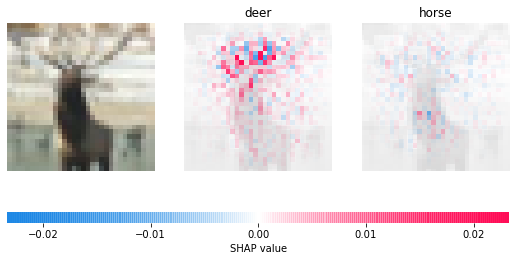

In [56]:
indices = deer_indices

samples = X_test[indices]
samples_prep = X_test_prep[indices]

samples_shap = explainer.shap_values(samples_prep)
compare_shap(samples_shap, [deer_class, horse_class], samples)

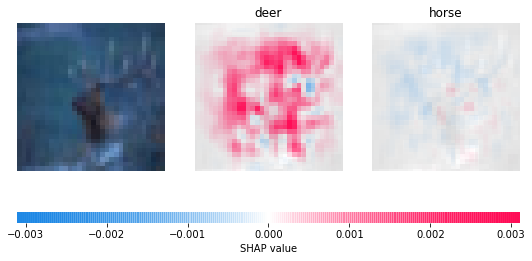

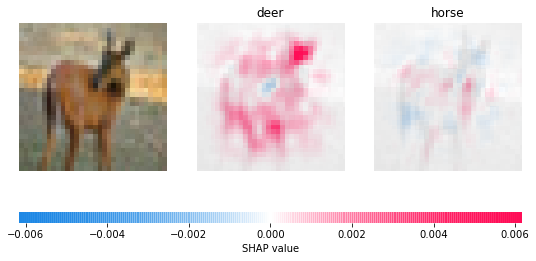

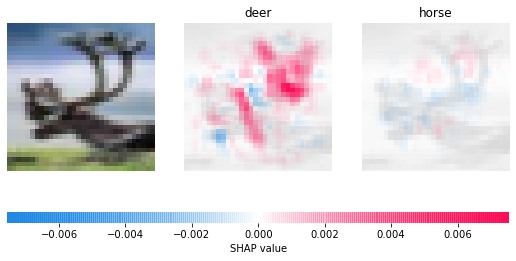

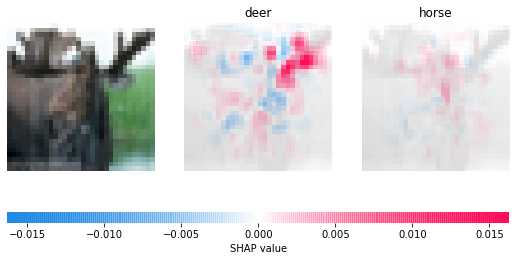

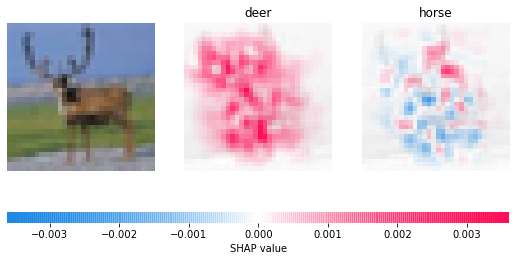

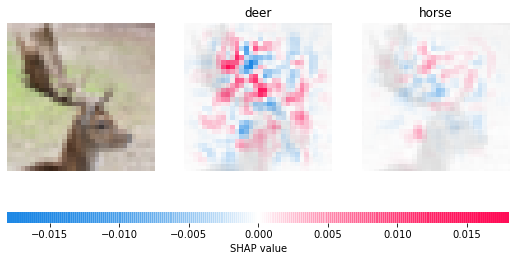

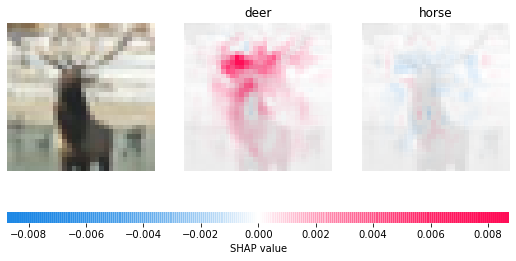

In [57]:
samples_shap_blurred = blur_shap_values(samples_shap, sigma=1)
compare_shap(samples_shap_blurred, [deer_class, horse_class], samples)

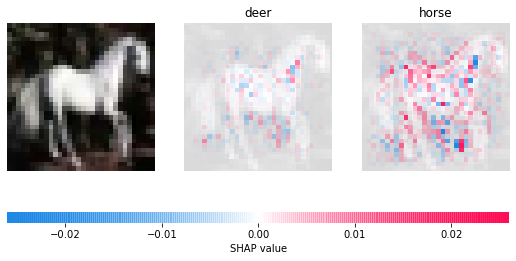

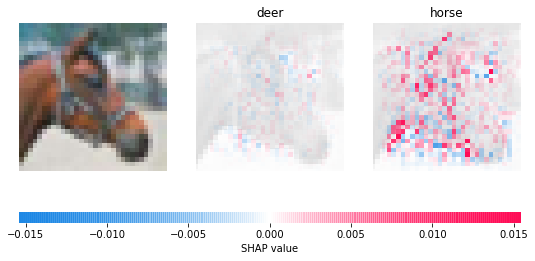

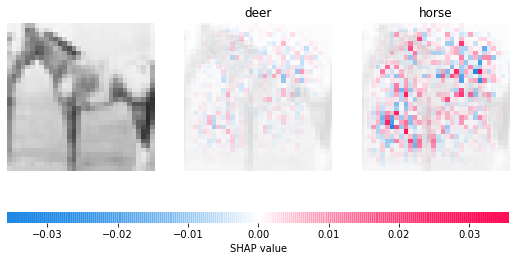

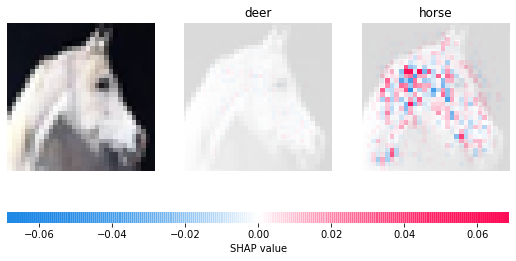

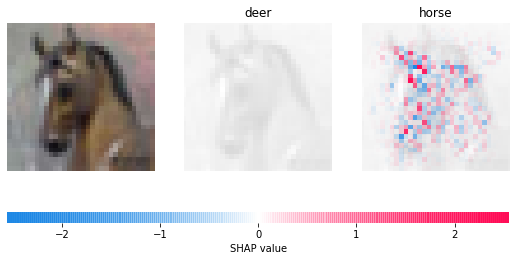

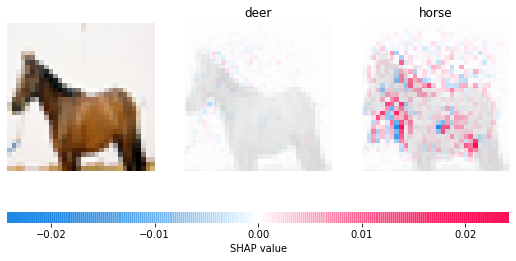

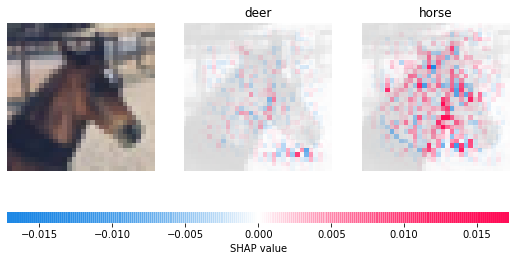

In [58]:
indices = horse_indices


samples = X_test[indices]
samples_prep = X_test_prep[indices]

samples_shap = explainer.shap_values(samples_prep)
compare_shap(samples_shap, [deer_class, horse_class], samples)

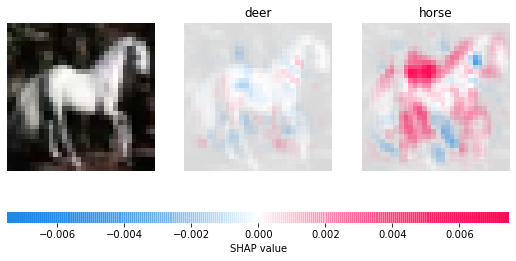

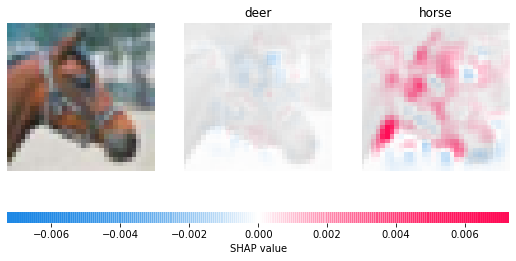

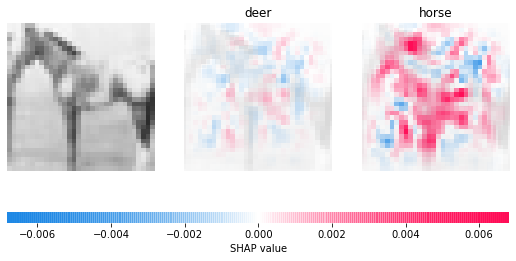

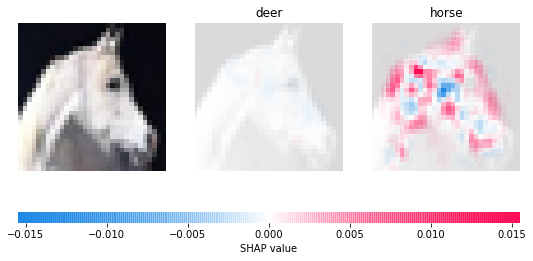

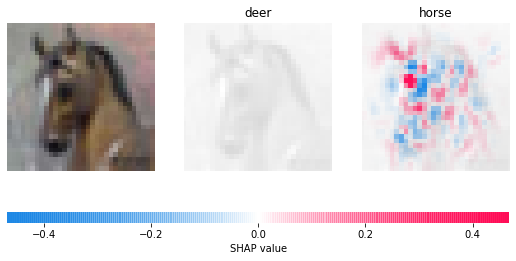

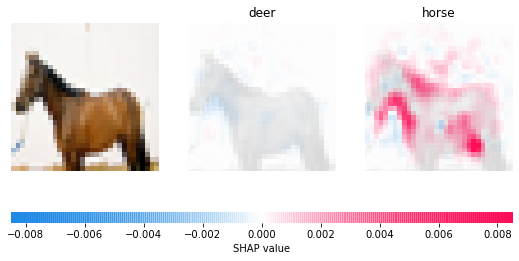

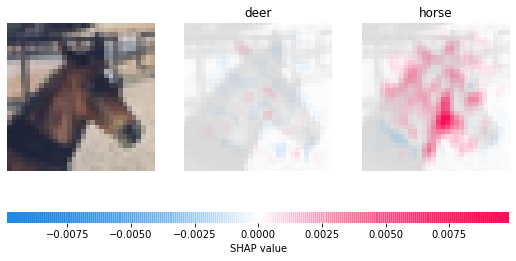

In [59]:
samples_shap_blurred = blur_shap_values(samples_shap, sigma=1)
compare_shap(samples_shap_blurred, [deer_class, horse_class], samples)

Zgodnie z oczekiwaniami, w przypadku rozróżniania jeleni kluczowe jest poroże. Bardzo ładnie jest to widoczne na większości zdjęć, gdy dla klasy jelenia poroże zaznaczone jest intensywnym czerwonym kolorem, natomiast dla klasy konia obszar poroża to kolor mocno niebieski. Charakterystyczne dla koni w większości przypadków są natomiast grzywy oraz szyje i żuchwa. Zdarza się również, że mocnym czerwonym kolorem zaznaczony jest jeździec na koniu.

## Selekcja próbek najłatwiejszych i najtrudniejszych do klasyfikacji

In [63]:
SAMPLES_PER_CLASS = 3

best_samples_indices = []
worst_samples_indices = []

for class_index in range(10):
    class_mask = y_test.flatten() == class_index
    class_preds = test_preds[:, class_index]
    indices = range(len(class_preds))
    
    best_preds_sorted = sorted(zip(class_preds * class_mask, indices), reverse=True)
    best_selected_indices = [i[1] for i in best_preds_sorted]
    best_samples_indices.append(best_selected_indices[:SAMPLES_PER_CLASS])
    
    worst_preds_sorted = sorted(zip((1 - class_preds) * class_mask, indices), reverse=True)
    worst_selected_indices = [i[1] for i in worst_preds_sorted]
    worst_samples_indices.append(worst_selected_indices[:SAMPLES_PER_CLASS])

Próbki sklasyfikowane poprawnie z największą pewnością


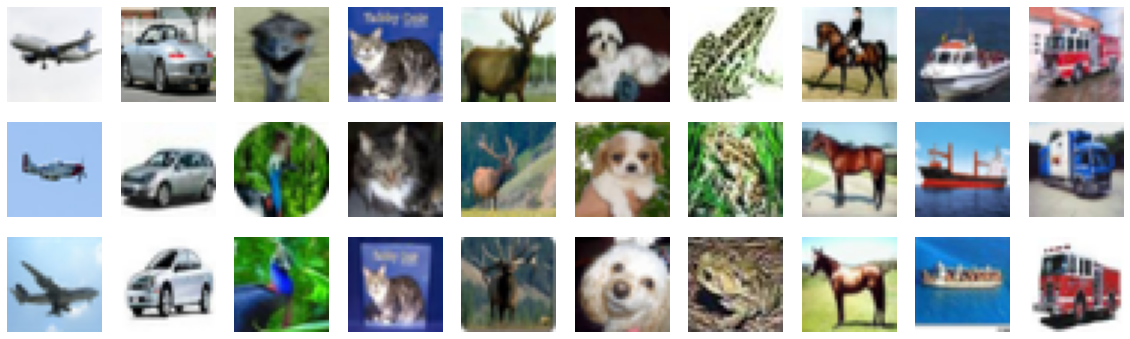

In [65]:
print('Próbki sklasyfikowane poprawnie z największą pewnością')
plt.figure(figsize=(20, 6))
for class_index, img_indices in enumerate(best_samples_indices):
    for sample_index, img_index in enumerate(img_indices):
        plt.subplot(SAMPLES_PER_CLASS, 10, sample_index * 10 + class_index + 1)
        plt.axis('off')
        plt.imshow(X_test[img_index])

Explaining dla próbek sklasyfikowanych poprawnie z największą pewnością (klasa airplane)


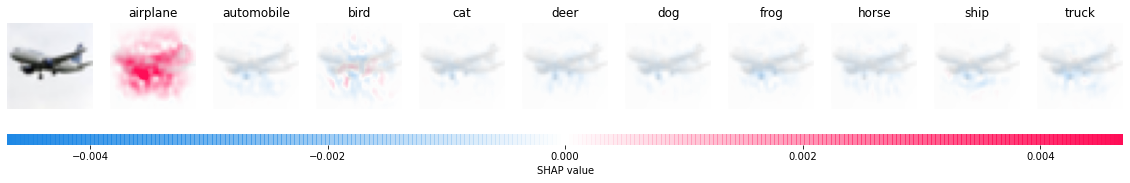

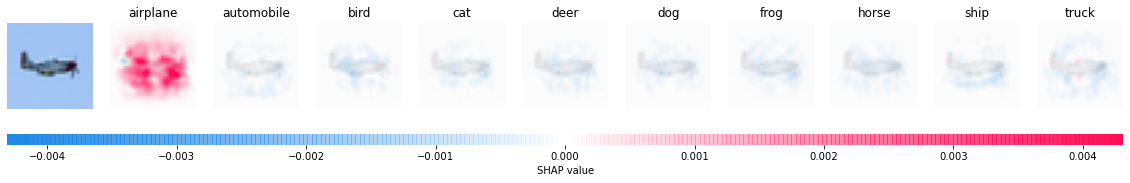

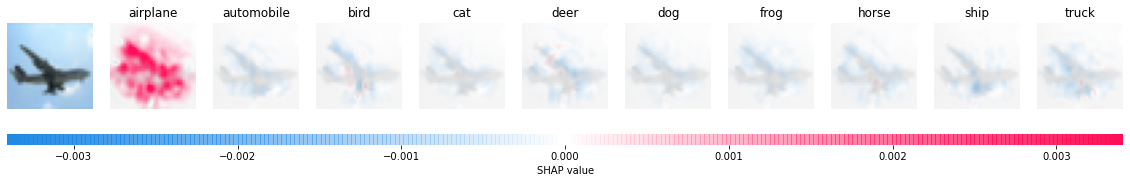

Explaining dla próbek sklasyfikowanych poprawnie z największą pewnością (klasa automobile)


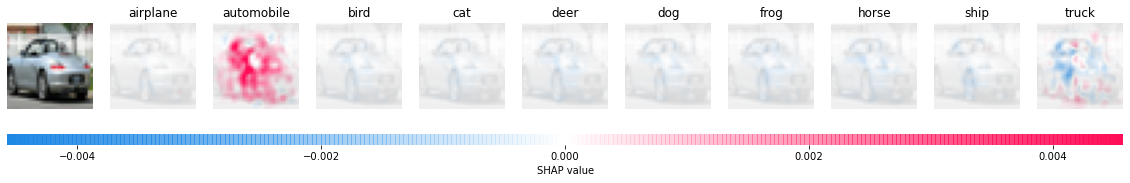

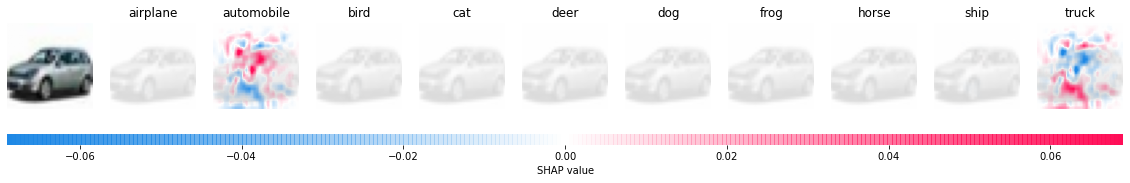

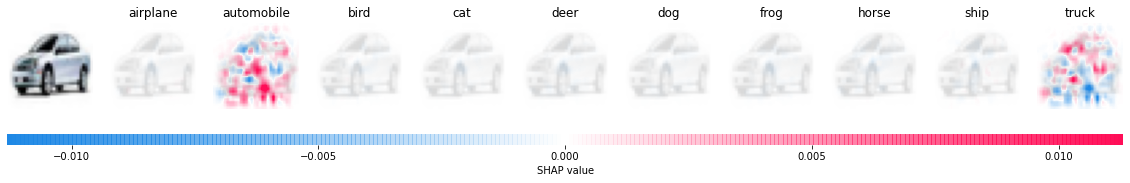

Explaining dla próbek sklasyfikowanych poprawnie z największą pewnością (klasa bird)


KeyboardInterrupt: 

In [111]:
for class_idx, samples_indices in enumerate(best_samples_indices):
    print(f'Explaining dla próbek sklasyfikowanych poprawnie z największą pewnością (klasa {class_names[class_idx]})')
    imgs = X_test[samples_indices]
    imgs_prep = X_test_prep[samples_indices]
    shap_values = explainer.shap_values(imgs_prep)
    shap_values_blurred = blur_shap_values(shap_values, sigma=1)
    
    for i, img in enumerate(imgs):
        shap_values_for_img = list(np.array(shap_values_blurred)[:, i:i+1])
        compare_shap(shap_values_for_img, list(range(10)), np.array([img]))

Próbki sklasyfikowane błędnie z największą pewnością


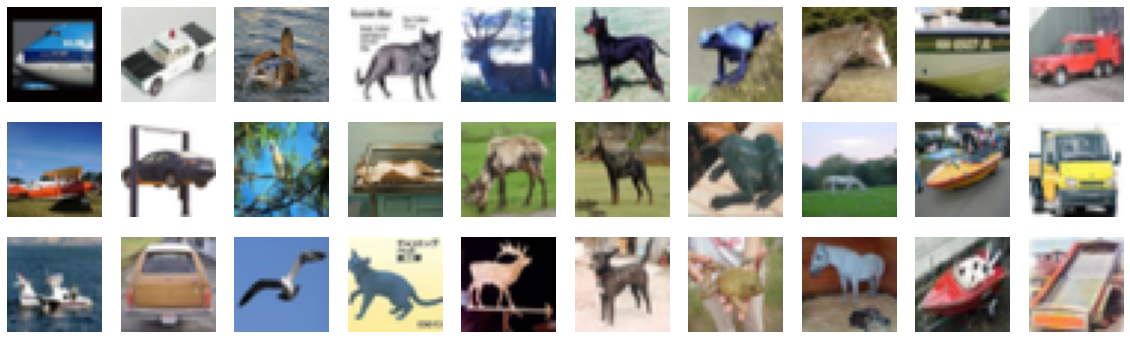

In [67]:
print('Próbki sklasyfikowane błędnie z największą pewnością')
plt.figure(figsize=(20, 6))
for class_index, img_indices in enumerate(worst_samples_indices):
    for sample_index, img_index in enumerate(img_indices):
        plt.subplot(SAMPLES_PER_CLASS, 10, sample_index * 10 + class_index + 1)
        plt.axis('off')
        plt.imshow(X_test[img_index])

Explaining dla próbek sklasyfikowanych błędnie z największą pewnością (klasa airplane)


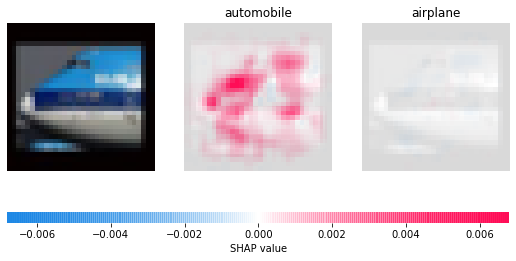

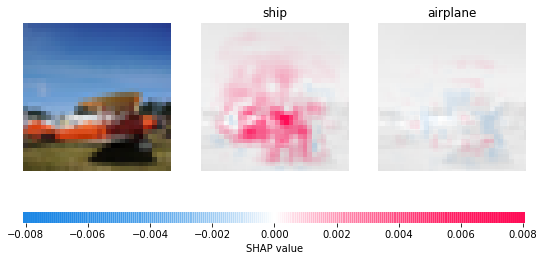

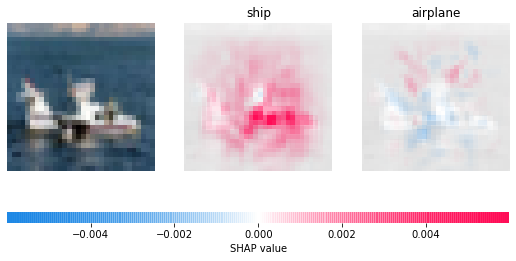

Explaining dla próbek sklasyfikowanych błędnie z największą pewnością (klasa automobile)


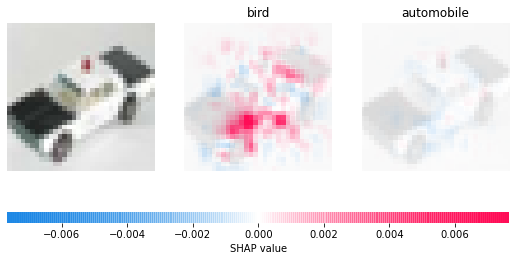

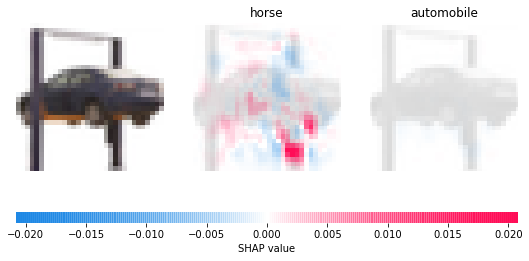

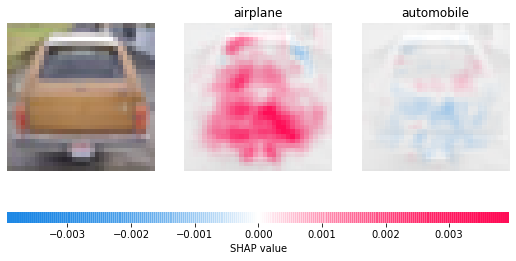

Explaining dla próbek sklasyfikowanych błędnie z największą pewnością (klasa bird)


KeyboardInterrupt: 

In [112]:
for class_idx, samples_indices in enumerate(worst_samples_indices):
    print(f'Explaining dla próbek sklasyfikowanych błędnie z największą pewnością (klasa {class_names[class_idx]})')
    imgs = X_test[samples_indices]
    imgs_prep = X_test_prep[samples_indices]
    true_labels = y_test[samples_indices]
    pred_labels = test_preds_classes[samples_indices]
            
    shap_values = explainer.shap_values(imgs_prep)
    shap_values_blurred = blur_shap_values(shap_values, sigma=1)
    
    for i, (img, true_label, pred_label) in enumerate(zip(imgs, true_labels, pred_labels)):
        shap_values_for_img = list(np.array(shap_values_blurred)[:, i:i+1])
        compare_shap(shap_values_for_img, [pred_label, true_label], np.array([img]))

## Selekcja próbek, dla których predykcja modelu jest wyrównana dla dwóch klas

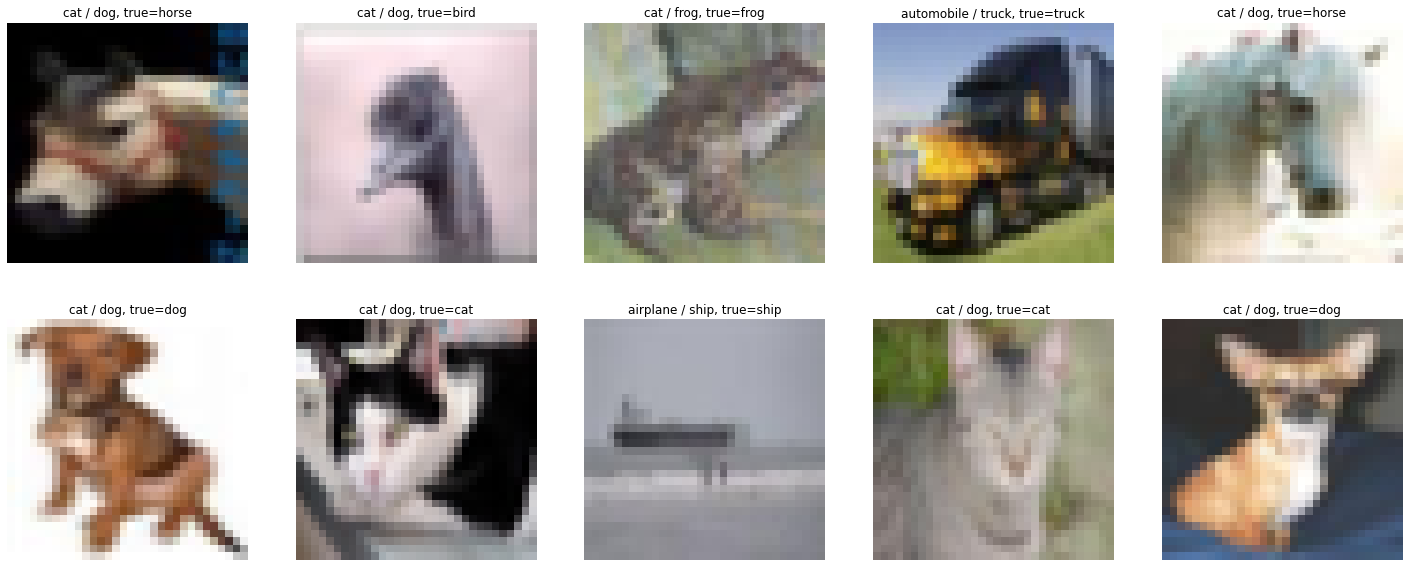

In [119]:
CONFUSING_SAMPLES_COUNT = 10
CONFIDENCE_THRESHOLD = 0.4

preds_above_threshold = test_preds > CONFIDENCE_THRESHOLD
confusing_preds_mask = np.sum(preds_above_threshold, axis=-1) > 1
confusing_samples_indices = np.argwhere(confusing_preds_mask)[:CONFUSING_SAMPLES_COUNT].flatten()
confusing_samples_preds = [np.argwhere(preds_above_threshold[i]).flatten() for i in confusing_samples_indices]

plt.figure(figsize=(25, 10))
for i, (sample_index, sample_preds) in enumerate(zip(confusing_samples_indices, confusing_samples_preds)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[sample_index])
    true_label = class_names[y_test[sample_index]]
    plt.title(f'{class_names[sample_preds[0]]} / {class_names[sample_preds[1]]}, true={true_label}')
    plt.axis('off')

Przewidziane klasy cat, dog
Rzeczywista klasa horse


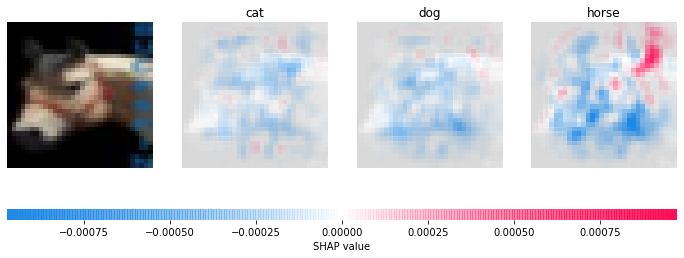

Przewidziane klasy cat, dog
Rzeczywista klasa bird


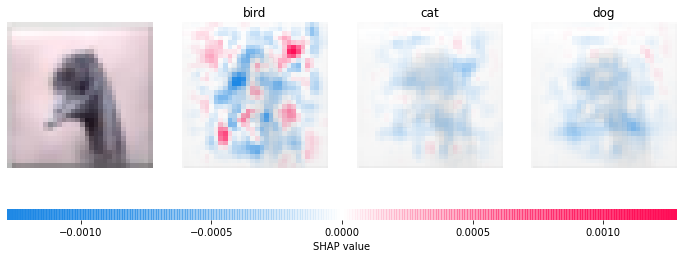

Przewidziane klasy cat, frog
Rzeczywista klasa frog


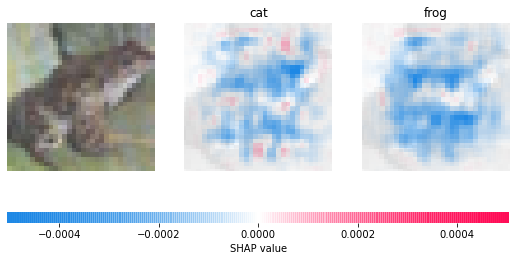

Przewidziane klasy automobile, truck
Rzeczywista klasa truck


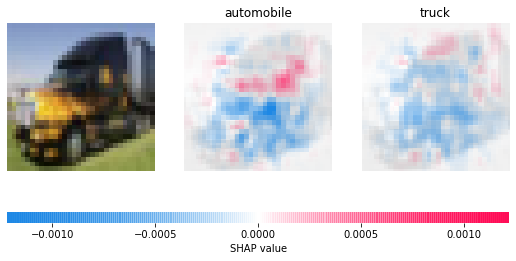

Przewidziane klasy cat, dog
Rzeczywista klasa horse


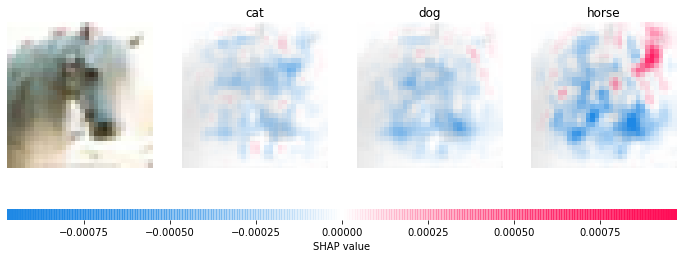

Przewidziane klasy cat, dog
Rzeczywista klasa dog


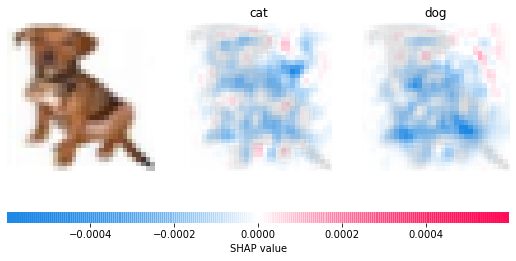

Przewidziane klasy cat, dog
Rzeczywista klasa cat


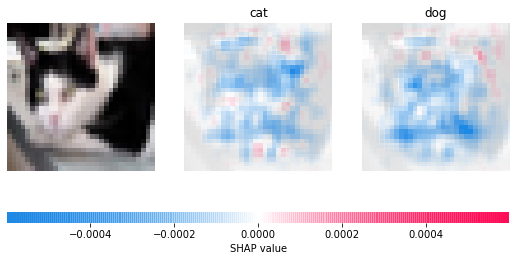

Przewidziane klasy airplane, ship
Rzeczywista klasa ship


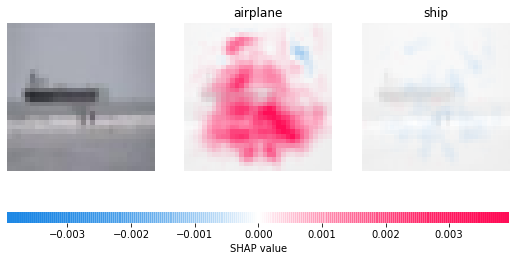

Przewidziane klasy cat, dog
Rzeczywista klasa cat


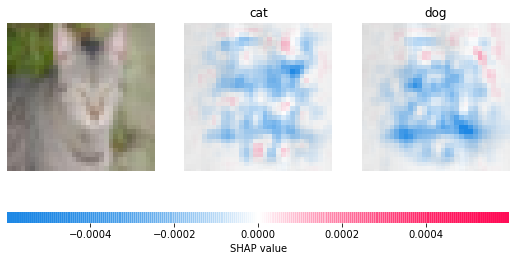

Przewidziane klasy cat, dog
Rzeczywista klasa dog


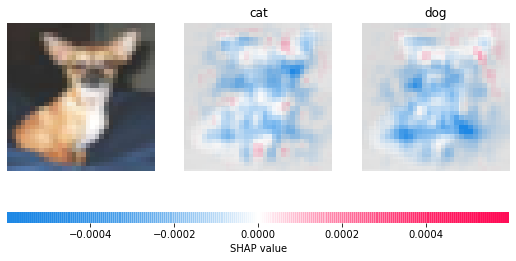

In [136]:
for sample_index, predicted_classes in zip(confusing_samples_indices, confusing_samples_preds):
    img = X_test[sample_index]
    img_prep = X_test_prep[sample_index]
    true_label = y_test[sample_index]
    print(f'Przewidziane klasy {class_names[predicted_classes[0]]}, {class_names[predicted_classes[1]]}')
    print(f'Rzeczywista klasa {class_names[true_label]}')
        
    shap_values = explainer.shap_values(np.array([img_prep]))
    shap_values_blurred = blur_shap_values(shap_values, sigma=1)
    explained_classes = np.unique(list(predicted_classes) + [true_label])
    compare_shap(shap_values_for_img, explained_classes, np.array([img]))

## Część laboratoryjna

Zadania dla studentów:

1) uzupełnianka kodu (wykorzystanie metody) - kod z explainowaniem kilku losowo wybranych probek

2) znajdz przynajmniej jedna pare klas, ktore sa ze soba mylone (albo przy pomocy pca, albo przy pomocy confusion matrix). znajdz kilka przykladow probek z kazdej z tych klas, dla ktorych shap dobrze pokazuje decydujace obszary zdjecia (w badaniu rezultatow moze pomoc zaaplikowanie rozmycia gaussowskiego, sprawdz wyniki dla roznego parametru sigma).

3) przetestuj dzialanie shap dla probek wyznazonych zgodnie z nastepujacymi zasadami:

- probki, ktore zostaly poprawnie sklasyfikowane przez model z najwieksza pewnoscia
- probki, ktore zostaly zupelnie sklasyfikowane z wysoka pewnoscia do zlej klasy
- probki, dla ktorych model waha sie pomiedzy dwoma klasami (predykcje dla obu klas zblizone do 50%)

sprawdz, czy shap pozwala zidentyfikowac problematyczne obszary na zdjeciu.

4) [dodatkowe] Przetestuj działanie explainerów dla różnych backgroundów (np. cały czarny obraz, średnia zbioru itp.). Sprobuj zinterpretowac wybrane probki przy uzyciu kernel explainera. 

In [ ]:
# rozne backgroundy
# background = np.zeros((1, 32, 32, 3))
# background = X_train_prep[np.random.choice(X_train_prep.shape[0], 100, replace=False)]
# background = np.mean(X_train_prep.reshape(-1, 32 * 32 * 3), axis=0).reshape(1, 32, 32, 3)
# explainer = shap.DeepExplainer(model, background)

## Wyjaśnienie próbek za pomocą DeepExplainer'a

In [64]:
%%time
# background = np.zeros((1, 32, 32, 3))
# background = X_train_prep[np.random.choice(X_train_prep.shape[0], 200, replace=False)]
background = np.mean(X_train_prep.reshape(-1, 32 * 32 * 3), axis=0).reshape(1, 32, 32, 3)
explainer = shap.DeepExplainer(model, background)

best_samples_shap = []
for class_index, samples_indices in tqdm(enumerate(best_samples_indices)):
    batch = X_test_prep[samples_indices]
    batch_shap = explainer.shap_values(batch)
    best_samples_shap.append(batch_shap)

worst_samples_shap = []
for class_index, samples_indices in tqdm(enumerate(worst_samples_indices)):
    batch = X_test_prep[samples_indices]
    batch_shap = explainer.shap_values(batch)
    worst_samples_shap.append(batch_shap)

10it [02:38, 15.88s/it]
10it [02:18, 13.89s/it]

CPU times: user 8min 51s, sys: 10.9 s, total: 9min 2s
Wall time: 4min 58s


In [ ]:
worst_samples_shap = []
for class_index, samples_indices in tqdm(enumerate(worst_samples_indices)):
    batch = X_test_prep[samples_indices]
    batch_shap = explainer.shap_values(batch)
    worst_samples_shap.append(batch_shap)

Explained Shapley values for sample 0


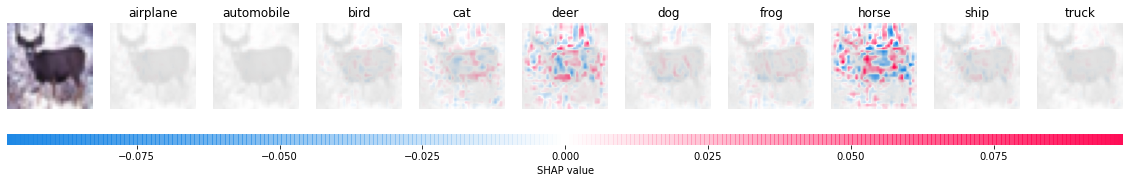

Explained Shapley values for sample 1


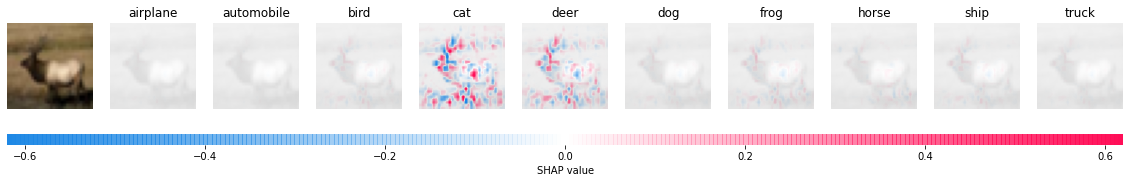

Explained Shapley values for sample 2


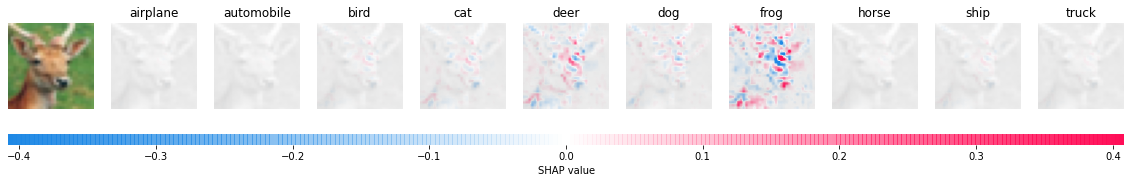

Explained Shapley values for sample 3


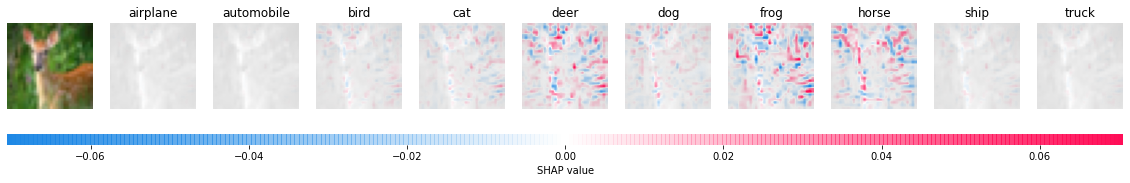

Explained Shapley values for sample 4


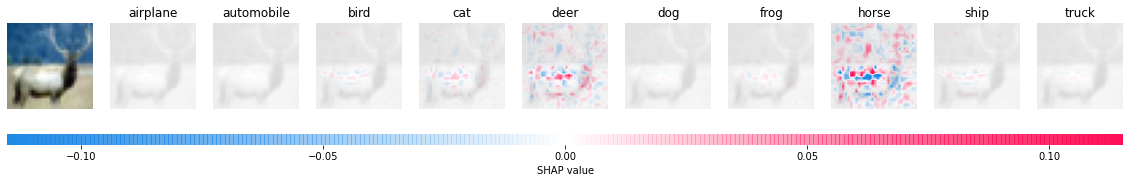

In [77]:
class_index = 4

plot_shap_values(shap_values=best_samples_shap[class_index],
                 classes_indices_to_explain=range(10),
                 samples_to_plot=[0, 1, 2, 3, 4], 
                 images=X_test[best_samples_indices[class_index]] / 255,
                 class_names=class_names)

## KernelExplainer

In [105]:
def predict_wrapper(model):
    def wrapped(flat_input):
        return model.predict(flat_input.reshape(-1, 32, 32, 3))
    
    return wrapped

In [106]:
np.mean(X_train, axis=0).reshape(1, -1).shape

(1, 3072)

In [110]:
%%time
background = np.zeros((1, 32, 32, 3)).reshape(1, -1)
explainer = shap.KernelExplainer(predict_wrapper(model), background)
shap_values = explainer.shap_values(images_to_explain.reshape(-1, 32 * 32 * 3))

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_


CPU times: user 1h 54min 25s, sys: 24min 42s, total: 2h 19min 8s
Wall time: 35min 7s


In [113]:
shhh = np.array(shap_values).reshape((10, TEST_SAMPLES_COUNT, 32, 32, 3))

Explained Shapley values for sample 0


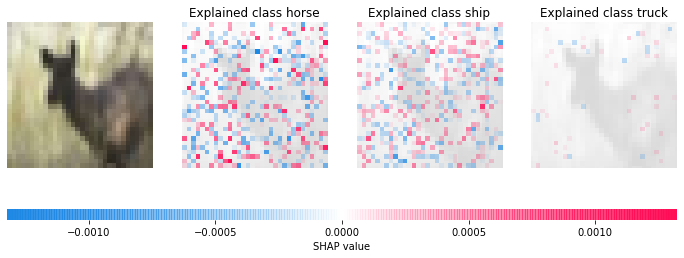

Explained Shapley values for sample 1


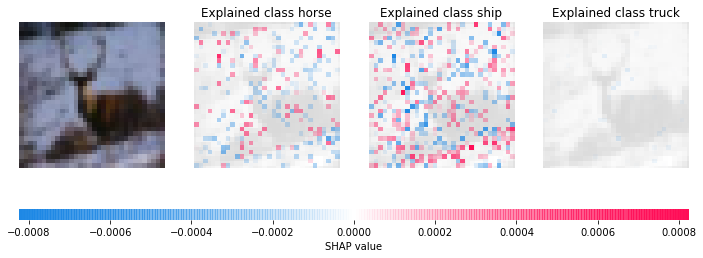

Explained Shapley values for sample 2


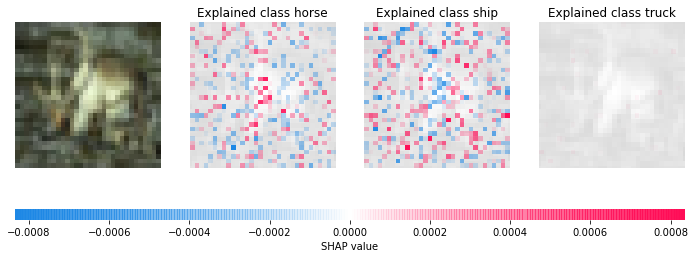

Explained Shapley values for sample 3


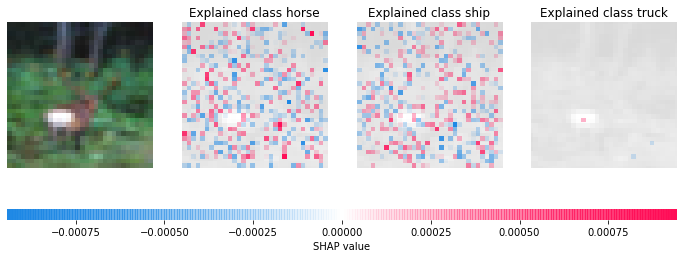

Explained Shapley values for sample 4


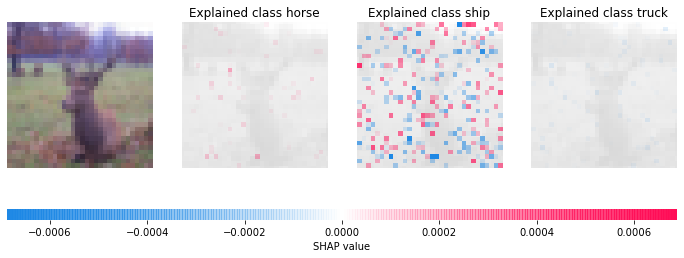

Explained Shapley values for sample 5


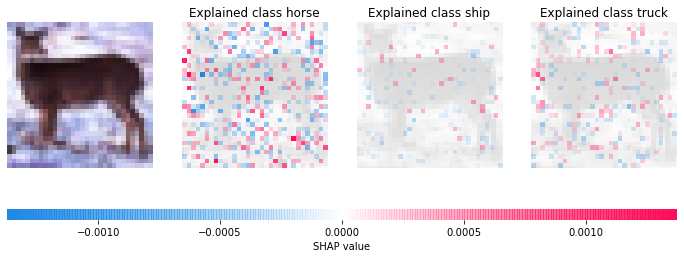

Explained Shapley values for sample 6


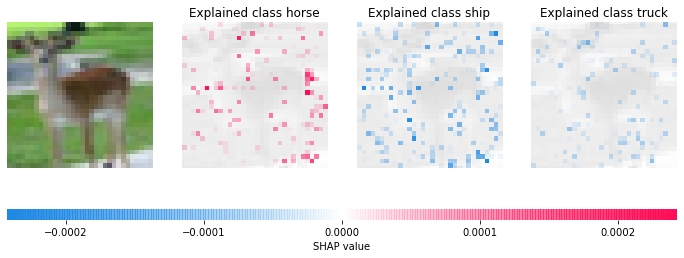

Explained Shapley values for sample 7


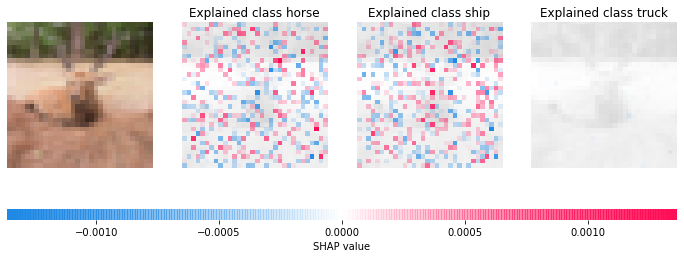

In [114]:
plot_shap_values(shap_values=list(shhh),
                 classes_indices_to_explain=[7, 8, 9], 
                 samples_to_plot=range(8), 
                 images=images_to_explain,
                 class_names=class_names)

Explained Shapley values for sample 0


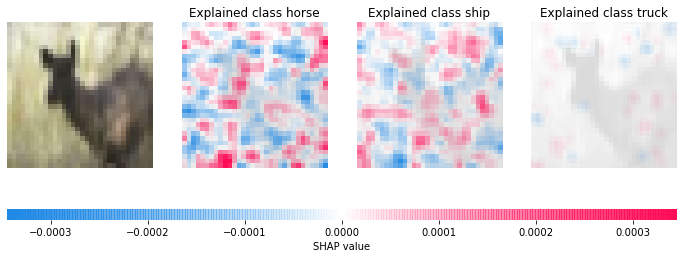

Explained Shapley values for sample 1


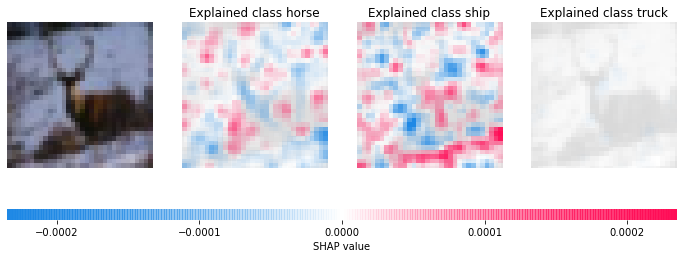

Explained Shapley values for sample 2


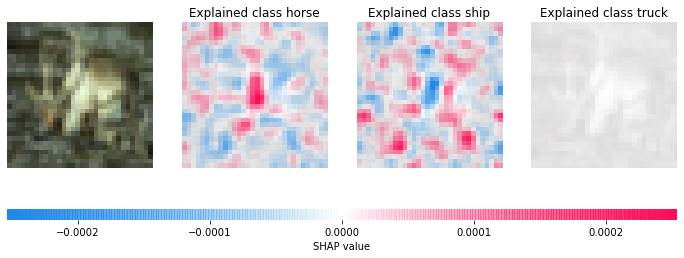

Explained Shapley values for sample 3


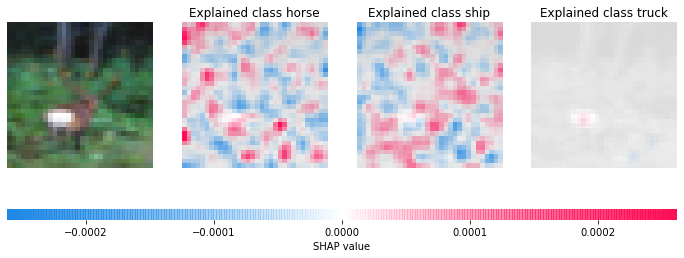

Explained Shapley values for sample 4


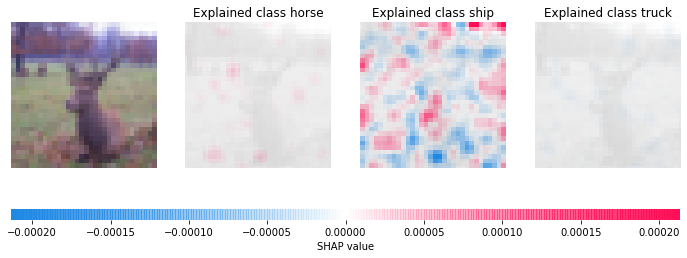

Explained Shapley values for sample 5


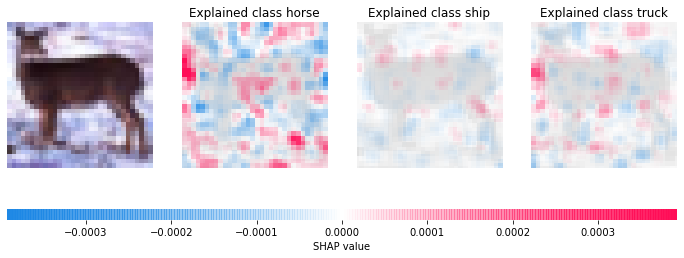

Explained Shapley values for sample 6


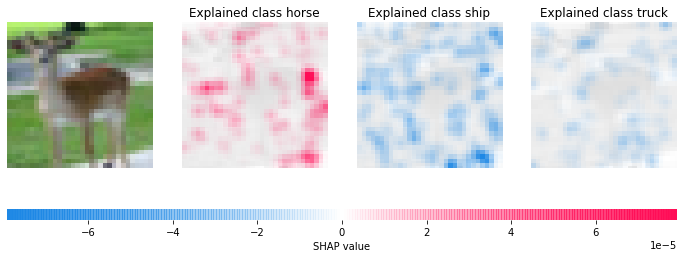

Explained Shapley values for sample 7


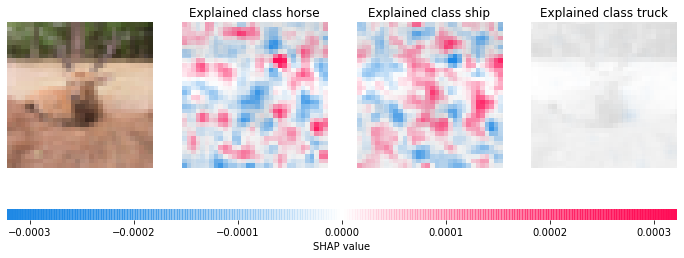

In [115]:
blurred_shhh = blur_shap_values(shhh, 1)
plot_shap_values(shap_values=list(blurred_shhh),
                 classes_indices_to_explain=[7, 8, 9], 
                 samples_to_plot=range(8), 
                 images=images_to_explain,
                 class_names=class_names)